<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 7 &ndash; Tricks of the Trade</h2>

<b>Authors:</b> Schlüter, Schörgenhumer<br>
<b>Date:</b> 23-01-2023

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u7_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u7_utils.py</code> need to be installed.

The following package is new: <code>fastai</code> (<a href="https://docs.fast.ai/#Installing">installation instructions</a>)

<details>
    <summary><code>fastai</code> might be a bit tricky to run if the versions of some modules (primarily <code>torch</code>) are not in line with the installed <code>fastai</code> version. If you have problems, here are the versions this notebook was originally run with, so you can install the exact same versions:</summary>
    <pre>
Installed Python      version: 3.9.10
Installed numpy       version: 1.22.4
Installed pandas      version: 1.4.3
Installed matplotlib  version: 3.5.1
Installed seaborn     version: 0.11.2
Installed torch       version: 1.12.0
Installed torchvision version: 0.13.0
Installed tqdm        version: 4.62.3
Installed fastai      version: 2.7.9
    </pre>
</details>

In [1]:
# Import pre-defined utilities specific to this notebook.
import u7_utils as u7

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch

from pathlib import Path

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u7.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [2]:
u7.check_module_versions()

Installed Python version: 3.10.7 (✓)
Installed numpy version: 1.23.3 (✓)
Installed pandas version: 1.5.0 (✓)
Installed matplotlib version: 3.6.1 (✓)
Installed seaborn version: 0.12.0 (✓)
Installed torch version: 1.12.1+cu116 (✓)
Installed torchvision version: 0.13.1+cu116 (✓)
Installed tqdm version: 4.64.1 (✓)
Installed fastai version: 2.7.10 (✓)


<h2 style="color:rgb(0,120,170)">Training a classifier in 5 minutes</h2>

We will start by demonstrating that we can train a classifier to reasonable accuracy in about <b>5 minutes on a dataset much more interesting than MNIST</b>. To make it more fun, we will train it on a dataset that does not even exist yet.

This part is adapted from a [fast.ai course notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) by Francisco Ingham and Jeremy Howard, which was in turn inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/), and a [fast.ai book chapter](https://github.com/fastai/fastbook/blob/master/02_production.ipynb).

<h3 style="color:rgb(0,120,170)">Step 1: Creating the dataset</h3>

We will create a dataset by downloading images found via a Google search. First, think of two or more classes you would like to use, and decide on a fitting name for the dataset:

In [3]:
#dataset_name = "burgers_and_burritos"
#dataset_name = "bridge_and_tower"
dataset_name = "dog_and_wolf"

We will go ahead and create a directory under `resources` for it:

In [4]:
dataset_path = Path(f"resources/{dataset_name}")
dataset_path.mkdir(parents=True, exist_ok=True)

Now let's fill it with data!

<h4 style="color:rgb(0,120,170)">Find images</h4>

1. Go to [Google Images](http://images.google.com) and search for a class you are interested in. The more specific you are in your query, the better the results (e.g., you may want to limit your results to only photos, and exclude search terms if needed, such as "apple -computer" when interested in the fruit only). Scroll down until you've seen all the images you want to download. All the images you scrolled past will be downloaded in the next step.
   

2. Now you need to run some JavaScript code in your browser which will save the URLs of all the images you want for you dataset. This needs to be run in the tab you used for the image search.

   In Firefox, press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>K</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>K</kbd> on Mac. In Google Chrome or Microsoft Edge, use <kbd>J</kbd> instead of <kbd>K</kbd>. In either case, a small window, the JavaScript 'Console', will appear. That is where you will paste the JavaScript commands.

   Script to scrape the URLs of all the images and print them to the console:

   ```javascript
   console.log(Array.from(document.querySelectorAll('.rg_i')).map(el=>el.getAttribute('src')).filter(Boolean).join('\n'));
   ```

   <br>(Firefox prevents pasting commands from the clipboard by default. To enable it, type "allow pasting" in the console and delete it again.)
   Copy the output to the clipboard (right-click, "Copy object" in Firefox; "Copy" button in Chrome/Edge). Switch to your jupyter "Home" tab (if you closed it, click "File -> Open..." in this notebook). Navigate to `resources/data/<dataset_name>`, click "New -> Text File" on the top right, and paste the URLs. On the top, rename the file from `untitled.txt` to a CSV file with the name of the class, such as `apple.csv`.
   
   Script with direct download (might be blocked by an ad-blocker):
   ```javascript
   urls=Array.from(document.querySelectorAll('.rg_i')).map(el=>el.getAttribute('src')).filter(Boolean);
   window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
   ```

   <br>Store the file to a CSV file with the name of the class, such as `apple.csv`.

Repeat these two steps with another search term for another target class. Two classes are the minimum, but you can also add more.

<h4 style="color:rgb(0,120,170)">Download images</h4>

We will now download the images from their respective URLs and store the images to separate subdirectories by calling the `u7.download_all_images` function:

In [5]:
u7.download_all_images(dataset_path)

<h4 style="color:rgb(0,120,170)">Look at images</h4>

Just to check that our dataset looks reasonable, let us plot some of the images:

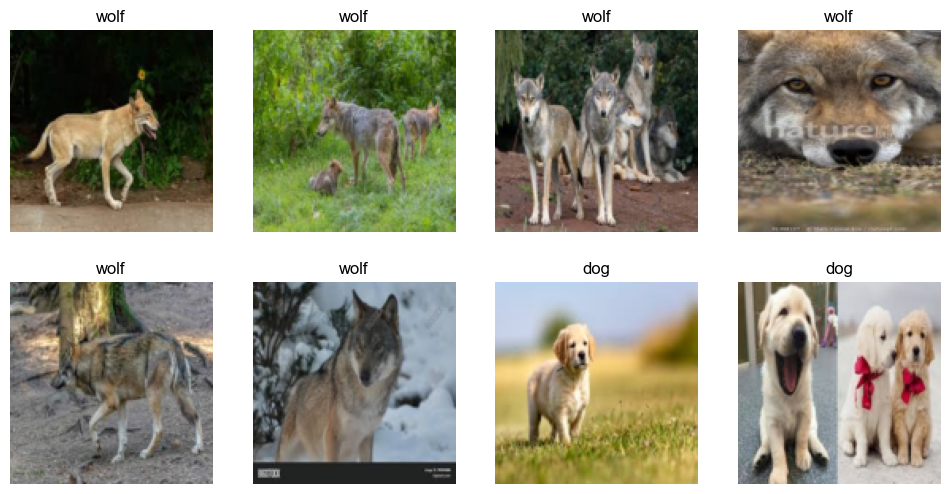

In [6]:
u7.set_seed(42)
u7.plot_image_dataset(dataset_path, nitems=8, nrows=2, size=128)

<h3 style="color:rgb(0,120,170)">Step 2: Training the classifier</h3>

We're now ready to train a classifier on these images. We'll reserve 20% of the data for validation, and train a classifier on the remainder.

In [7]:
u7.set_seed(42)
result = u7.perform_magic(dataset_path, valid_size=0.2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\andua/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.791932,0.118772,0.033333,01:07
1,0.378024,0.139649,0.041667,01:11
2,0.230719,0.164568,0.058333,01:11
3,0.160596,0.162775,0.050000,01:13


<h3 style="color:rgb(0,120,170)">Step 3: Evaluating the classifier</h3>

We can already see how the error rate on the validation set went down. Let's investigate some more. We first precompute some predictions and metrics:

In [8]:
evaluator = u7.evaluate_classifier(result)

We can now plot a confusion matrix, giving us the number of images for every combination of prediction and true label. An ideal classifier only has values on the main diagonal, where label and prediction match.

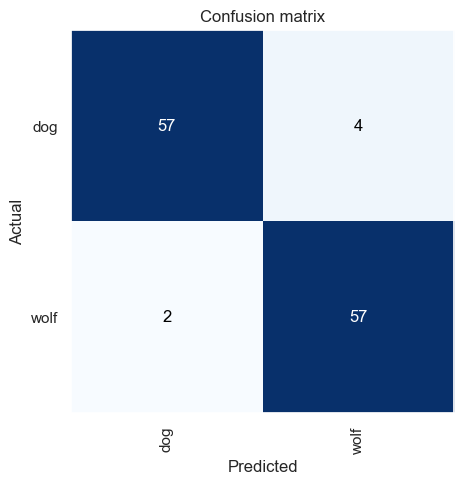

In [9]:
evaluator.plot_confusion_matrix()

Let's see where it went wrong (if any):

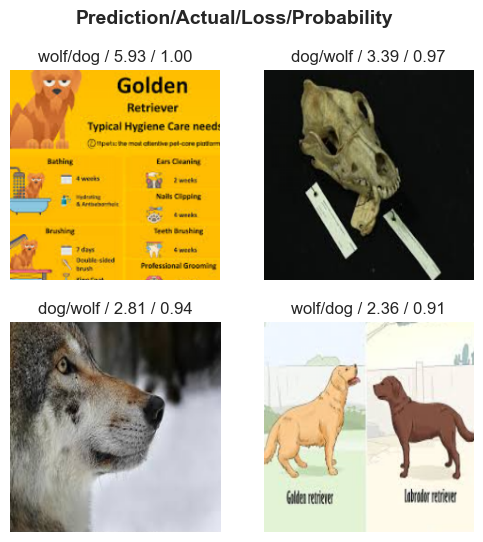

In [10]:
evaluator.plot_top_losses(4)

<h2 style="color:rgb(0,120,170)">How was this possible?</h2>

What are the magic ingredients? What does the **model** look like? How can we train it so **quickly** from so **few images**?

Let's start from scratch, with a setup similar to what we used in the last lecture.

Note: For reproducibility reasons, some of the steps are within a single code cell with multiple calls to `u7.set_seed` in between.

<h3 style="color:rgb(0,120,170)">Defining the dataset and the model</h3>

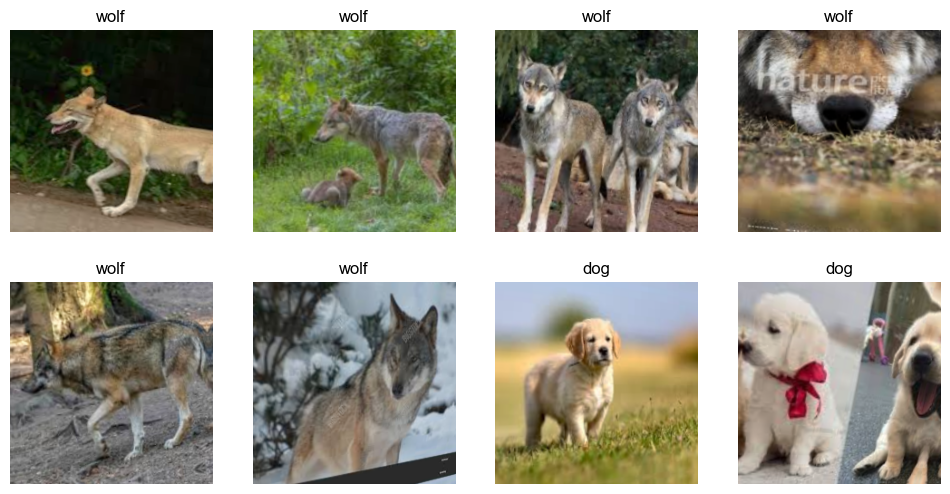

In [11]:
#
# Defininig the dataset
#

u7.set_seed(42)
dataset = u7.load_image_dataset(
    dataset_path,
    valid_size=0.2,  # keep 20% for validation
    batch_size=32,   # reduce if you run out of RAM
    augment=True     # whether to use augmentation
)

# comment this out if you want to skip the example image visualization
dataset.show_batch(
    max_n=8, nrows=2,  # how many images to show in how many rows
    unique=False       # set to True to see effect of augmentation
)



#
# Defining the model and the loss
#

u7.set_seed(42)
model = u7.create_cnn(
    num_classes=dataset.c,
    num_layers=5,      # try larger models: 18, 34, 50, 101 or 152 (these are already predefined for you)
    batchnorm=False,   # whether to use batch normalization
    dropout=0,         # try 0.5 for 50% dropout or 0.25 for 25% dropout
    residuals=False,   # whether to use residual connections
    pretrained=False   # whether to use pretrained weights
)
loss = torch.nn.functional.cross_entropy

# uncomment this to see the full architecture in detail
# print(model)

u7.set_seed(42)  # already as preparation for the next step: "Training the model"

<h3 style="color:rgb(0,120,170)">Training the model</h3>

  0%|          | 0/480 [00:00<?, ?it/s]

Epoch  1 finished with training loss: 0.695372 and validation loss: 0.692790
Epoch  2 finished with training loss: 0.694018 and validation loss: 0.692679
Epoch  3 finished with training loss: 0.692927 and validation loss: 0.692642
Epoch  4 finished with training loss: 0.691962 and validation loss: 0.692533


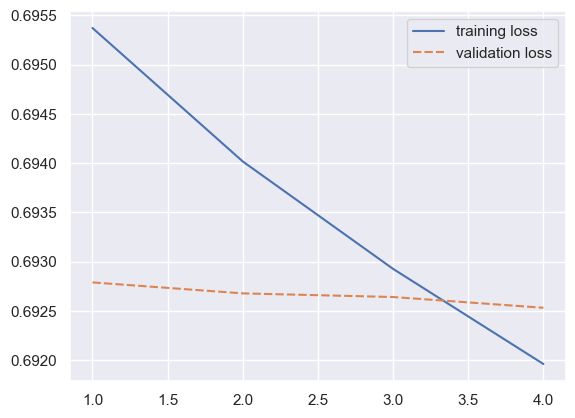

In [12]:
# run this cell multiple times to train the model further
u7.run_gradient_descent(
    model=model,
    loss=loss,
    training_set=dataset.train,
    valid_set=dataset.valid,
    iterations=4,         # number of epochs
    learning_rate=0.001,  # base learning rate
    momentum=0.9,         # base momentum
    lr_schedule=None,     # try "linear", "onecycle", "steps"
    plot_curves=True
);

<h3 style="color:rgb(0,120,170)">Evaluating the model</h3>

In [13]:
print("Training set:")
print(u7.evaluate_model(model, dataset.train, loss=loss, error_rate=u7.multiclass_error_rate))
print("Validation set:")
print(u7.evaluate_model(model, dataset.valid, loss=loss, error_rate=u7.multiclass_error_rate))

Training set:
{'loss': 0.6911224047342936, 'error_rate': 0.475}
Validation set:
{'loss': 0.6925326287746429, 'error_rate': 0.5104166567325592}


<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Improve the scores! Can you match the error rate of the <code>u7.perform_magic()</code> call in Step 2? What are the most important ingredients?</li>
        <li>Aspects to vary:
            <ul>
                <li>use data augmentation</li>
                <li>use dropout</li>
                <li>use batch normalization</li>
                <li>enlarge the model</li>
                <li>use residual connections</li>
                <li>use a pretrained model</li>
                <li>use a learning rate schedule</li>
            </ul>
        </li>
    </ul>
</div>

<details>
    <summary>Hints if you are stuck:</summary>
    <ul>
        <li>Use a bigger model size, e.g., 18 or 34.</li>
        <li>Enable batch normalization.</li>
        <li>Enable residual connections.</li>
        <li>Use a pretrained model.</li>
    </ul>
</details>